# The Pipeline for comparision of Lenskit, Surprise and Caserec frameworks implementing the User-based K-nearest neighbours algorithm

### Loading the MovieLens 100k Dataset Using Pandas

In [1]:
import numpy as np
import pandas as pd
import math
from numpy import mean

In [2]:
data_path = r'C:\Users\SaiKrishna Rao Anugu\OneDrive\Desktop\RecSys- Project\ml-100k/u.data'# This is the path of the u.data file\
# of the movielens 100k dataset, you need to download the movielens 100k dataset and copy paste the u.data file path here

data = pd.read_csv(data_path, sep = '\t', header = None, names = ['user', 'item', 'rating', 'timestamp'])# data in text format\
                                                                                                        #converted to pandas DataFrame
data.head()# to view the first 5 rows of dataset

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### spliting the dataset into 5-folds using partition_users() method from Lenskit

In [3]:
import lenskit
from lenskit import crossfold as xf

In [4]:
# created the train_set and test_set list and using the partition_users splitted the data and appended all the 5 folds train&test
#sets in to the lists created.
num_of_folds = 5
train_set = []
test_set = []
for (train, test) in xf.partition_users(data, 5, xf.SampleFrac(0.2)):
    train_set.append(train)
    test_set.append(test)
print(len(train_set[0]))
print(len(test_set[0]))

91740
3789


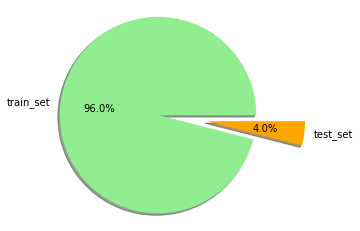

In [5]:
#A pie chart of a single fold dataset with portions of train_set and test_set
import matplotlib.pyplot as plt 
pie_data = {'train_set' :len(train_set[0]), 'test_set': len(test_set[0])}
explode = (0,0.5)
colors = ['lightgreen', 'orange']
plt.pie(pie_data.values(), explode=explode, labels=pie_data.keys(),colors=colors, autopct='%1.1f%%', shadow= True, startangle= 0)
plt.axis('equal')
plt.show()

## Predicting ratings for the users using UserKNN algorithm with:

## Lenskit

In [6]:
import lenskit
from lenskit import datasets,util 
from lenskit import algorithms
from lenskit.algorithms import Recommender, als, user_knn as knn
from lenskit import crossfold as xf
from lenskit.batch import predict
import lenskit.metrics.predict as pm

In [7]:
# created a lenksit_model list, then appended the 5 different models for 5 folds (using userknn algorithm ) into list created
lenskit_model = []
for i in range(num_of_folds):
    lenskit_model.append(lenskit.algorithms.user_knn.UserUser(nnbrs = 40, min_nbrs=1, min_sim=0, feedback='explicit'))
    

In [8]:
# defined a fuction called get_ratings_and_predictions, where the parameters are the models we created above and train, test
# sets from each fold
def get_ratings_and_predictions(model, train_set, test_set):
    #model = lenskit.algorithms.user_knn.UserUser(nnbrs = 40, min_nbrs=1, min_sim= 0, feedback='explicit')
    model.fit(train_set)
    preds = predict(model, test_set)
    preds['prediction'] = preds['prediction'].fillna(0)
    ratings_list = (preds['rating'].values.tolist())
    predictions_list =(preds['prediction'].values.tolist())
    return ratings_list, predictions_list
    

In [9]:
#created all_ratings_list, all_predictions_list for which we append the ratings and predictions for every fold by calling the
# get_ratings_and_predictions function which is defined earlier
all_ratings_list = []
all_predictions_list = []
for i in range(num_of_folds):
    a,b = get_ratings_and_predictions(lenskit_model[i],train_set[i], test_set[i])
    all_ratings_list.append(a)
    all_predictions_list.append(b)

BLAS using multiple threads - can cause oversubscription
found 1 potential runtime problems - see https://boi.st/lkpy-perf


In [10]:
#defined a function called Mectric_Eval, by which we can calculate RMSE and MAE values for each fold
def Metric_Eval(ratings, predictions):
    mae_total = 0
    rmse_total = 0
    for i in range(len(predictions)):
        mae_value = np.abs(ratings[i] - predictions[i])
        rmse_value = (ratings[i] - predictions[i])**2
        mae_total = mae_total + mae_value
        rmse_total = rmse_total + rmse_value

    mae =  mae_total / (len(ratings))
    rmse =  np.sqrt(rmse_total / (len(ratings)))
    return rmse,mae

In [11]:
#created rmse_list and mae_list, where we can collect the rmse and mae values of all the folds in to the lists by calling
# the Metric_Eval function which is defined above
rmse_list = []
mae_list= []
for i in range(num_of_folds):
    r, m = Metric_Eval(all_ratings_list[i],all_predictions_list[i])
    rmse_list.append(r)
    mae_list.append(m)

In [12]:
# here calculating the mean of rmse of all the folds
lenskit_rmse = np.mean(rmse_list)

In [13]:
# here calculating the mean of mae of all the folds
lenskit_mae = np.mean(mae_list)

In [14]:
#printing the rmse and mae metric values of lenskit model
print("lenskit_rmse: ",lenskit_rmse)  
print ("lenskit_mae: ",lenskit_mae)

lenskit_rmse:  0.9450171505134115
lenskit_mae:  0.7339649834199072


# Surprise

In [15]:
import surprise
import os
from surprise import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.algo_base import AlgoBase

In [16]:
#UserKNN algorithm of Surprise framework
sim_options = {'name' : 'cosine', 'user_based' : True}
model = KNNWithMeans(k = 40, min_k = 1, sim_options = sim_options, verbose = True )

In [17]:
#created surprise trainsets from the trainsets (which we get from lenskit partition_user method), using build_full_trainset() method 
surprise_train_set = []
for i in range(num_of_folds):
    reader = Reader(rating_scale=(1, 5))
    surprise_train_set.append(Dataset.load_from_df(train_set[i][['user', 'item', 'rating']], reader = reader).build_full_trainset())

In [18]:
#Converted userid, itemid and ratings from the pandas DataFrame to the lists, so we can use them for getting the predictions
user_list = []
item_list = []
rating_list =[]
for i in range(num_of_folds):
    user_list.append(test_set[i].user.values.tolist())
    item_list.append(test_set[i].item.values.tolist())
    rating_list.append(test_set[i].rating.values.tolist())

In [19]:
# created a surprise_model list, where appended the 5 different models for 5 folds (using userknn algorithm ) into list created
surprise_model = []
for i in range(num_of_folds):
    surprise_model.append(KNNWithMeans(k = 40, min_k = 1, sim_options = sim_options, verbose = True ))
    

In [20]:
#defined a function called get_predictions, where the parameters are the model, trainset, testset, userid, itemid
#it just return the predictions list.
def get_predictions(model,train_set,test_set,userid,itemid):
    model.fit(train_set)
    predictions = []
    for i in range(len(test_set)):
        preds = model.predict(userid[i], itemid[i])
        predictions.append(preds.est)
    return predictions
            
        

In [21]:
#created a loop for collecting predictions from 5 folds, by applying 5 models created above
all_folds_predictions = []
for i in range(num_of_folds):
    surprise_predictions = get_predictions(surprise_model[i],surprise_train_set[i], test_set[i],user_list[i],item_list[i])
    all_folds_predictions.append(surprise_predictions)
        

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [22]:
# called the Metric_Eval function and created lists for collecting rmse and mae values from all the folds.
surprise_rmse_list = []
surprise_mae_list= []
for i in range(num_of_folds):
    r, m = Metric_Eval(rating_list[i],all_folds_predictions[i])
    surprise_rmse_list.append(r)
    surprise_mae_list.append(m)

In [23]:
#calculating the mean for rmse and mae values of 5 folds
surprise_rmse = np.mean(surprise_rmse_list)
surprise_mae = np.mean(surprise_mae_list)

In [24]:
# printing the rmse & mae values which are the mean values of all the folds
print("surprise_rmse: ",surprise_rmse)  
print ("surprise_mae: ", surprise_mae)

surprise_rmse:  0.9573285712983213
surprise_mae:  0.753144033435494


# CaseRec

In [25]:
from caserec.recommenders.rating_prediction.user_attribute_knn import UserAttributeKNN
from caserec.recommenders.rating_prediction.item_attribute_knn import ItemAttributeKNN
from caserec.recommenders.rating_prediction.itemknn import ItemKNN
from caserec.recommenders.rating_prediction.userknn import UserKNN
from caserec.utils.cross_validation import CrossValidation
from caserec.utils.split_database import SplitDatabase
from caserec.evaluation.rating_prediction import RatingPredictionEvaluation
from caserec.utils.process_data import ReadFile

In [26]:
# converted the trainset(from partition_users(lenskit)) into file format and saved in the directory
#NOTE : when you run this cell the train_sets from all the folds are saved as text files, in a folder where actually jupyter files
# are saved
caserec_trainset_1 = train_set[0].to_csv('train_set[0]', sep = '\t', header = False, index = False)
caserec_trainset_2 = train_set[1].to_csv('train_set[1]', sep = '\t', header = False, index = False)
caserec_trainset_3 = train_set[2].to_csv('train_set[2]', sep = '\t', header = False, index = False)
caserec_trainset_4 = train_set[3].to_csv('train_set[3]', sep = '\t', header = False, index = False)
caserec_trainset_5 = train_set[4].to_csv('train_set[4]', sep = '\t', header = False, index = False)

In [27]:
# converted the testset(from partition_users(lenskit)) into file format and saved in the directory
#NOTE : when you run this cell the test_sets from all the folds are saved as text files, in a folder where actually jupyter files
# are saved
caserec_testset_1 = test_set[0].to_csv('test_set[0]', sep = '\t', header = False, index = False)
caserec_testset_2 = test_set[1].to_csv('test_set[1]', sep = '\t', header = False, index = False)
caserec_testset_3 = test_set[2].to_csv('test_set[2]', sep = '\t', header = False, index = False)
caserec_testset_4 = test_set[3].to_csv('test_set[3]', sep = '\t', header = False, index = False)
caserec_testset_5 = test_set[4].to_csv('test_set[4]', sep = '\t', header = False, index = False)

In [28]:
# these are the text document directory paths of 5 fold trainsets, which we converted them from dataframe above
#NOTE:These are the paths of the files saved in the folder of my pc, it will be different in your case. So please copy and paste
#the paths of the directory where the data has been saved in your pc, when you convert the dataframs to files 
caserec_trainset_filepath_1 = r"C:\Users\SaiKrishna Rao Anugu\train_set[0]"
caserec_trainset_filepath_2 = r"C:\Users\SaiKrishna Rao Anugu\train_set[1]"
caserec_trainset_filepath_3 = r"C:\Users\SaiKrishna Rao Anugu\train_set[2]"
caserec_trainset_filepath_4 = r"C:\Users\SaiKrishna Rao Anugu\train_set[3]"
caserec_trainset_filepath_5 = r"C:\Users\SaiKrishna Rao Anugu\train_set[4]"
caserec_trainset_filepath = [caserec_trainset_filepath_1,caserec_trainset_filepath_2,caserec_trainset_filepath_3,caserec_trainset_filepath_4,caserec_trainset_filepath_5]

In [29]:
# these are the text document  directory paths of 5 fold testsets, which we converted them from dataframe above
# NOTE: These are the paths of the files saved in the folder of my pc, it will be different in your case. So please copy and paste
#the paths of the directory where the data has been saved in your pc, when you convert the dataframs to files 
caserec_testset_filepath_1 = r"C:\Users\SaiKrishna Rao Anugu\test_set[0]"
caserec_testset_filepath_2 = r"C:\Users\SaiKrishna Rao Anugu\test_set[1]"
caserec_testset_filepath_3 = r"C:\Users\SaiKrishna Rao Anugu\test_set[2]"
caserec_testset_filepath_4 = r"C:\Users\SaiKrishna Rao Anugu\test_set[3]"
caserec_testset_filepath_5 = r"C:\Users\SaiKrishna Rao Anugu\test_set[4]"
caserec_testset_filepath = [caserec_testset_filepath_1,caserec_testset_filepath_2,caserec_testset_filepath_3,caserec_testset_filepath_4,caserec_testset_filepath_5]

In [30]:
#created 5 prediction text documents manually in one of the folder in my pc, and pasted the paths of them here, So when we run 
#the model all the predictions of 5 folds will be saved in these text documents via these paths
# NOTE: These text document files should me manually created and named as below and their paths should be copied and pasted here
# Therefore when we run the compute method, all the calculated prediction values are going to be saved in the text documents 
# through these paths
predictions_output_filepath_1= r"C:\Users\SaiKrishna Rao Anugu\predictions_output_1.dat"
predictions_output_filepath_2= r"C:\Users\SaiKrishna Rao Anugu\predictions_output_2.dat"
predictions_output_filepath_3= r"C:\Users\SaiKrishna Rao Anugu\predictions_output_3.dat"
predictions_output_filepath_4= r"C:\Users\SaiKrishna Rao Anugu\predictions_output_4.dat"
predictions_output_filepath_5= r"C:\Users\SaiKrishna Rao Anugu\predictions_output_5.dat"
predictions_output_filepath= [predictions_output_filepath_1,predictions_output_filepath_2,predictions_output_filepath_3,predictions_output_filepath_4,predictions_output_filepath_5]

In [31]:
#created 5 different models for 5 folds using userknn algorithm 
caserec_model = []
for i in range(num_of_folds):
    model = UserKNN(caserec_trainset_filepath[i],caserec_testset_filepath[i],output_file = predictions_output_filepath[i], similarity_metric="cosine", k_neighbors= 40)
    caserec_model.append(model)  

In [32]:
#defined a function called get_predictions_caserec, from which we can get predictions of 5 folds by giving 5 models as parameters 
def get_predictions_caserec(model):
    model.compute(verbose_evaluation = False, verbose = False)        

In [33]:
#created loop for getting all the 5 folds predictions
for i in range(num_of_folds):
    get_predictions_caserec(caserec_model[i])

### Now converting the predictions files to Pandas DataFrame

In [34]:
# converting the predictions text file to pandas dataframe
caserec_prediction_df = []
for i in range(num_of_folds):
    caserec_prediction_df.append(pd.read_csv(predictions_output_filepath[i], sep = '\t', header = None, names = ['user', 'item', 'prediction']))
len(caserec_prediction_df[0])

3789

In [35]:
# sorted the ratings of test_sets of all the folds by user then the items, because the predictions in the prediction df are sorted
# in the same way. So inorder to compare both for calculating the metrics, both should be similarly sorted
for i in range(num_of_folds):
    test_set[i]= test_set[i].sort_values(by=["user", 'item'])

In [36]:
# This is to prove that both testset and prediction dataframes are sorted by user and then item, similarly
print(test_set[0])
print(caserec_prediction_df[0])

       user  item  rating  timestamp
50664     6     7       2  883599102
65371     6     9       4  883599205
7774      6    28       2  883603013
41450     6    71       4  883601053
3672      6    95       2  883602133
...     ...   ...     ...        ...
87633   933  1188       1  874938474
71352   941   117       5  875048886
95587   941   273       3  875049038
92090   941   300       4  875048495
80319   941   475       4  875049038

[3789 rows x 4 columns]
      user  item  prediction
0        6     7    3.871828
1        6     9    4.123576
2        6    28    3.565317
3        6    71    3.390334
4        6    95    3.338825
...    ...   ...         ...
3784   933  1188    2.055035
3785   941   117    3.802881
3786   941   273    3.864283
3787   941   300    3.927043
3788   941   475    3.937500

[3789 rows x 3 columns]


In [37]:
#converted all the ratings and prediction values to lists from dataframe
caserec_rating_list = []
caserec_prediction_list=[]
for i in range(num_of_folds):
    caserec_rating_list.append(test_set[i]['rating'].values.tolist())
    caserec_prediction_list.append(caserec_prediction_df[i]['prediction'].values.tolist())
print(len(caserec_rating_list[0]))
print(len(caserec_prediction_list[0]))

3789
3789


In [38]:
#called the Metric_Eval function and collected rmse and mae values of 5 folds into lists
caserec_rmse_list = []
caserec_mae_list= []
for i in range(num_of_folds):
    r, m = Metric_Eval(caserec_rating_list[i],caserec_prediction_list[i])
    caserec_rmse_list.append(r)
    caserec_mae_list.append(m)

In [39]:
#calculated the mean for rmse and mae values of 5 folds
caserec_rmse = np.mean(caserec_rmse_list)
caserec_mae = np.mean(caserec_mae_list)

In [40]:
print("caserec_rmse: ",caserec_rmse)  
print ("caserec_mae: ",caserec_mae)

caserec_rmse:  0.9423402656857676
caserec_mae:  0.7351002079582669


### Plotting the bar chart for comparing the metric values of the three libraries

In [41]:
#created a pandas dataframe where rows are library names and columns are metric values
RMSE = [lenskit_rmse, surprise_rmse, caserec_rmse]
MAE = [lenskit_mae, surprise_mae, caserec_mae]
d = {'RMSE': RMSE, 'MAE': MAE}
df = pd.DataFrame(d, index = ['lenskit', 'surprise', 'caserec'])
df

,RMSE,MAE
lenskit,0.945017,0.733965
surprise,0.957329,0.753144
caserec,0.942340,0.735100


Text(0, 0.5, 'ERROR')

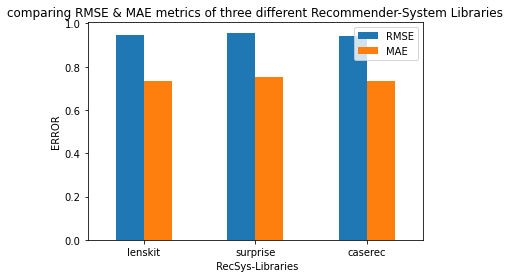

In [42]:
#plotted a bar chart for the data in the above dataframe using pandas and matplotlib
ax = df.plot.bar(rot = 0)
from matplotlib import pyplot as plt
plt.title("comparing RMSE & MAE metrics of three different Recommender-System Libraries")
plt.xlabel(" RecSys-Libraries")
plt.ylabel("ERROR")